# Table of Contents
* [loading data](#loading-data)
* [object counts](#object-counts)
* [image brightness](#image-brightness)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [146]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [165]:
import glob
import os
import json
import re
import PIL.Image as Image
import PIL.ImageStat as ImageStat

from multiprocessing import Pool

# loading data

In [27]:
all_ds_files = glob.glob('./SUNRGBD/**', recursive=True)
len(all_ds_files)

410709

In [39]:
image_names = [iname for iname in all_ds_files if 'image/' in iname]

In [40]:
len(image_names)

10335

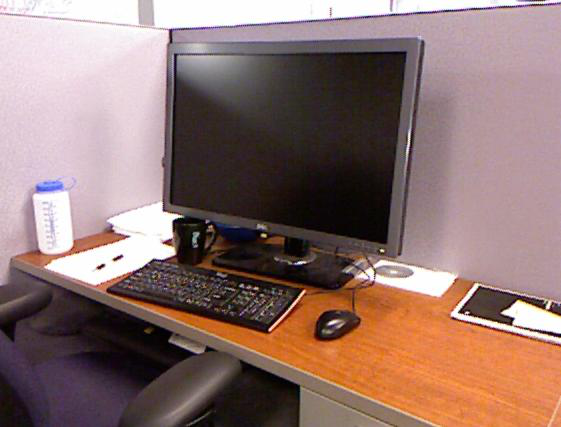

In [46]:
Image.open(image_names[50])

In [53]:
anno_names = [iname for iname in all_ds_files if 'annotation/' in iname and not 'json_' in iname]

In [102]:
ts1 = './SUNRGBD/kv2/align_kv2/2014-12-18_11-31-54_260595134347/annotation/index.json'
img_pattern = re.compile('.*(img_[0-9]+|NYU[0-9]+|[0-9]+_[0-9]+|[0-9]+-[0-9]+).*')
re.findall(img_pattern, ts1)

['4_260595134347']

In [121]:
sun_rgb_anno = {}
dedupe_count = 0
for ann_fn in anno_names:
    try:
        img_n = re.findall(img_pattern, ann_fn)[0]
    except IndexError as e:
        print(ann_fn, e)
    with open(ann_fn, 'r') as f:
        try:
            img_annotation = json.load(f)
        except json.JSONDecodeError as e:
            print(ann_fn, img_n)
    sun_rgb_anno[str(dedupe_count) + img_n] = img_annotation
    dedupe_count += 1

./SUNRGBD/kv1/b3dodata/img_0139/annotation/index.json img_0139
./SUNRGBD/kv1/b3dodata/img_0174/annotation/index.json img_0174
./SUNRGBD/kv2/kinect2data/000424_2014-06-08_17-05-00_260595134347_rgbf000115-resize/annotation/index.json 0_260595134347
./SUNRGBD/kv2/kinect2data/000467_2014-06-09_19-35-24_260595134347_rgbf000188-resize/annotation/index.json 4_260595134347
./SUNRGBD/kv2/kinect2data/000504_2014-06-08_23-03-02_260595134347_rgbf000064-resize/annotation/index.json 2_260595134347
./SUNRGBD/kv2/kinect2data/000631_2014-06-08_16-30-36_260595134347_rgbf000088-resize/annotation/index.json 6_260595134347
./SUNRGBD/kv2/kinect2data/000667_2014-06-09_21-06-12_260595134347_rgbf000145-resize/annotation/index.json 2_260595134347
./SUNRGBD/kv2/kinect2data/000668_2014-06-09_21-07-12_260595134347_rgbf000161-resize/annotation/index.json 2_260595134347
./SUNRGBD/kv2/kinect2data/001177_2014-06-17_15-46-38_260595134347_rgbf000056-resize/annotation/index.json 8_260595134347
./SUNRGBD/kv2/kinect2data/0

In [110]:
img_numbs = sorted([i.split('/')[-1].split('.jpg')[0] for i in image_names])

In [115]:
twenss = [i for i in image_names if '0000027' in i]

In [122]:
len(sun_rgb_anno)

10335

In [124]:
test_anno = list(sun_rgb_anno.values())[50]

# object counts

In [135]:
object_counts = Counter()
for image_anno in sun_rgb_anno.values():
    objects = [obj['name'] for obj in image_anno['objects'] if obj]
    object_counts.update(objects)

In [144]:
freq_series = pd.Series(list(object_counts.values()))

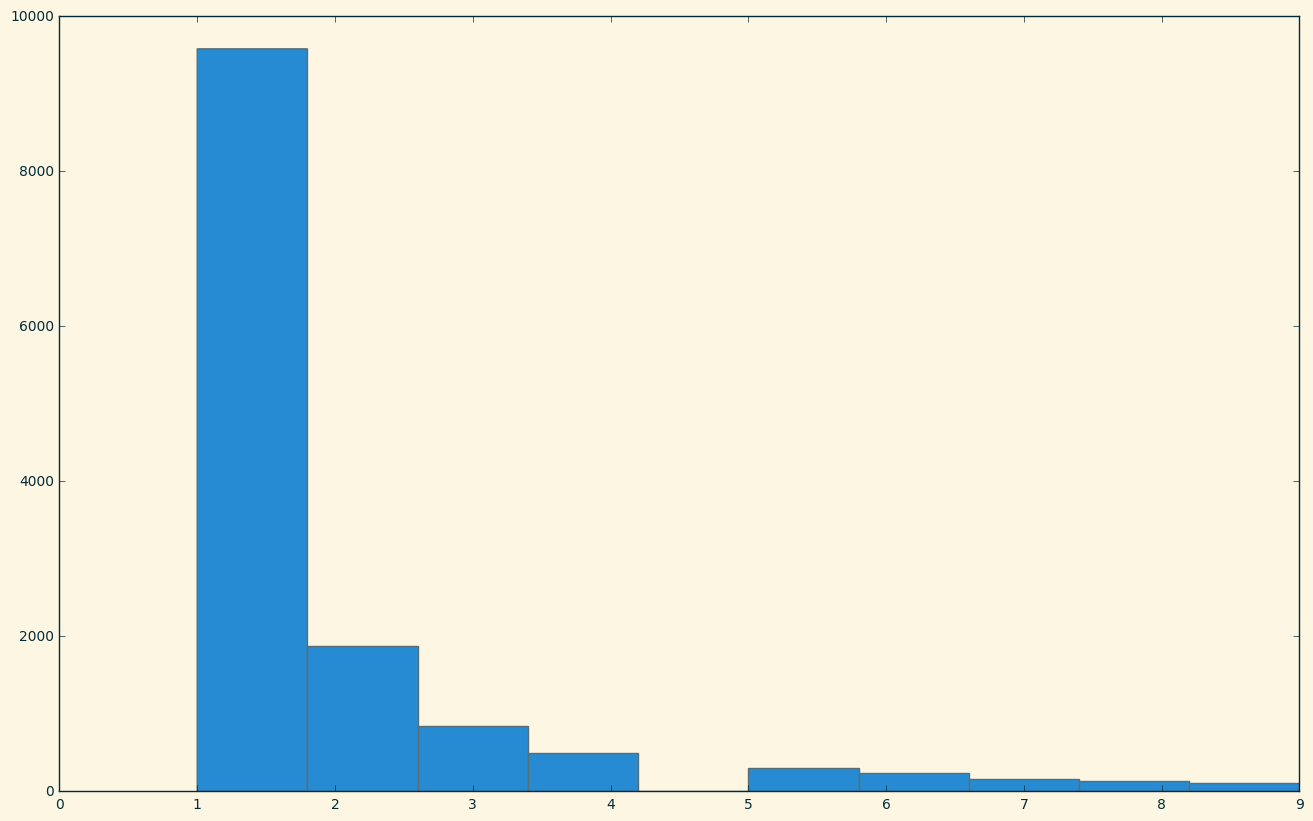

In [158]:
_ = freq_series[freq_series < 10].hist()

In [139]:
object_counts.most_common()

[('wall', 14281),
 ('chair', 13289),
 ('floor', 9387),
 ('table', 5484),
 ('Chair', 3597),
 ('window', 3174),
 ('picture', 3008),
 ('Wall', 2771),
 ('door', 2429),
 ('pillow', 2214),
 ('cabinet', 2163),
 ('Floor', 2146),
 ('paper', 1875),
 ('desk', 1846),
 ('box', 1826),
 ('book', 1693),
 ('books', 1431),
 ('bottle', 1369),
 ('Table', 1363),
 ('lamp', 1291),
 ('CHAIR', 1258),
 ('WALL', 1154),
 ('shelf', 1141),
 ('bed', 1129),
 ('sofa', 1111),
 ('ceiling', 1090),
 ('light', 1010),
 ('monitor', 961),
 ('bag', 896),
 ('FLOOR', 803),
 ('Window', 790),
 ('curtain', 789),
 ('cup', 761),
 ('mirror', 690),
 ('keyboard', 672),
 ('Desk', 661),
 ('counter', 648),
 ('Door', 591),
 ('drawer', 583),
 ('sign', 521),
 ('clothes', 514),
 ('couch', 507),
 ('TABLE', 498),
 ('sink', 495),
 ('dresser', 476),
 ('mouse', 474),
 ('shelves', 462),
 ('bookshelf', 460),
 ('computer', 454),
 ('towel', 453),
 ('blinds', 423),
 ('outlet', 421),
 ('plant', 413),
 ('Pillow', 394),
 ('bowl', 385),
 ('unknown', 383),
 

# image brightness

In [175]:
def mean_pixel_level(img_file):
   img = Image.open(img_file).convert('L')
   img_stats = ImageStat.Stat(img)
   return img_stats.mean[0]

def compute_img_brightnesses(image_files):
    img_brightnesses = {}
    for img in image_files:
#         img_brightnesses[img.split('/')[-1]] = mean_pixel_level(img)
        img_brightnesses[img] = mean_pixel_level(img)
    return img_brightnesses

In [176]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

img_split = np.array_split(image_names, n_processes)
pool_results = pool.map(compute_img_brightnesses, img_split)
img_brightnesses = {}
for res in pool_results:
    img_brightnesses.update(res)

CPU times: user 102 ms, sys: 66.9 ms, total: 169 ms
Wall time: 27.4 s


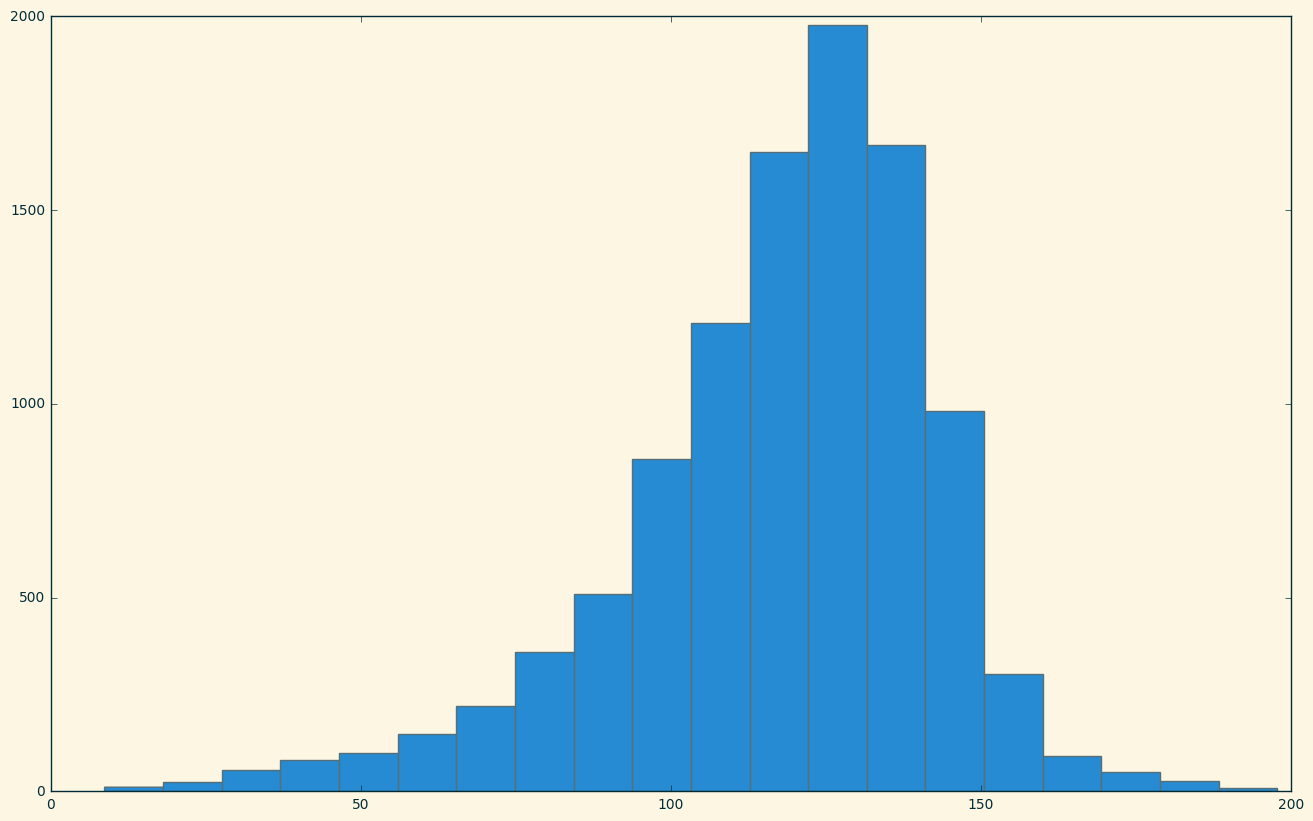

In [177]:
_ = pd.Series(list(img_brightnesses.values())).hist(bins=20)

In [178]:
dim_images = {k: v for k, v in img_brightnesses.items() if v < 50}

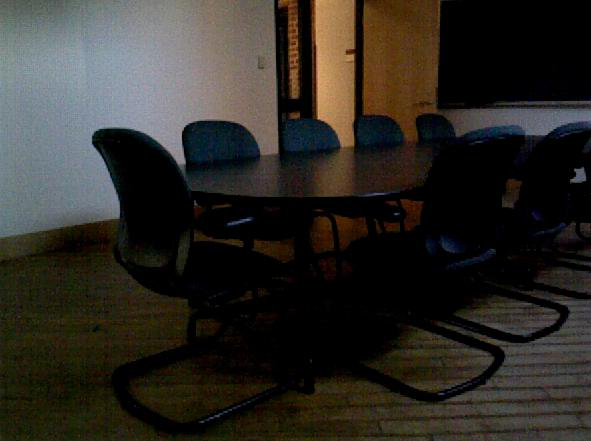

In [183]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()
Image.open(random_img)